In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
print('TF',tf.__version__)

TF 2.5.0


/home/nguyenlienviet/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nguyenlienviet/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nguyenlienviet/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nguyenlienviet/.local/lib/python3.6/site

In [11]:
BASE = '../data/train_images/'

In [2]:
train = pd.read_csv('../data/train.csv')

In [17]:
model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=None)

In [18]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=BASE): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
train_gen = DataGenerator(train, batch_size=128)
image_embeddings = model.predict(train_gen,verbose=1)

268/268 [==============================] - 271s 991ms/step


In [8]:
from sklearn.neighbors import NearestNeighbors
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(image_embeddings)
distances, indices = model.kneighbors(image_embeddings)

In [14]:
def displayDF(train, random=False, COLS=6, ROWS=4, path=BASE):
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            if random: row = np.random.randint(0,len(train))
            else: row = COLS*k + j
            name = train.iloc[row,1]
            title = train.iloc[row,3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path+name)
            plt.subplot(1,COLS,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()

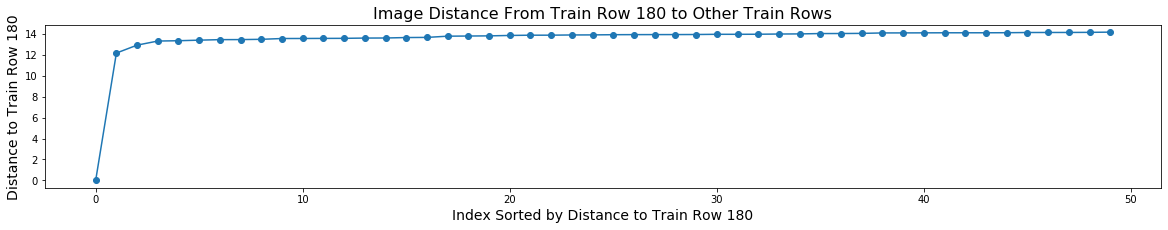

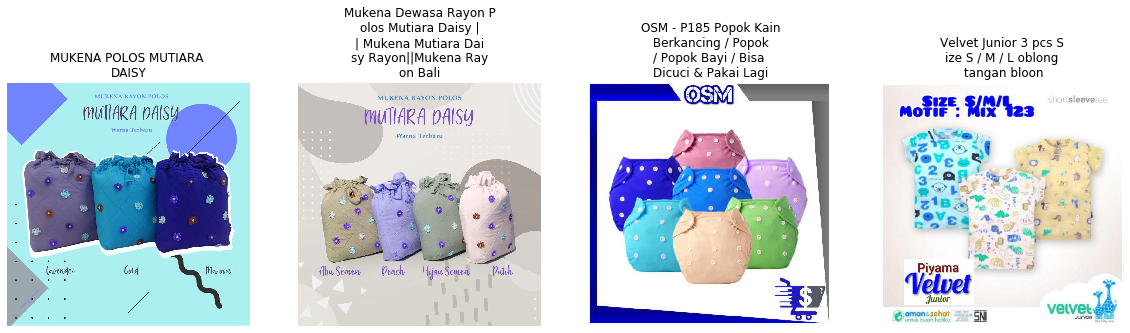

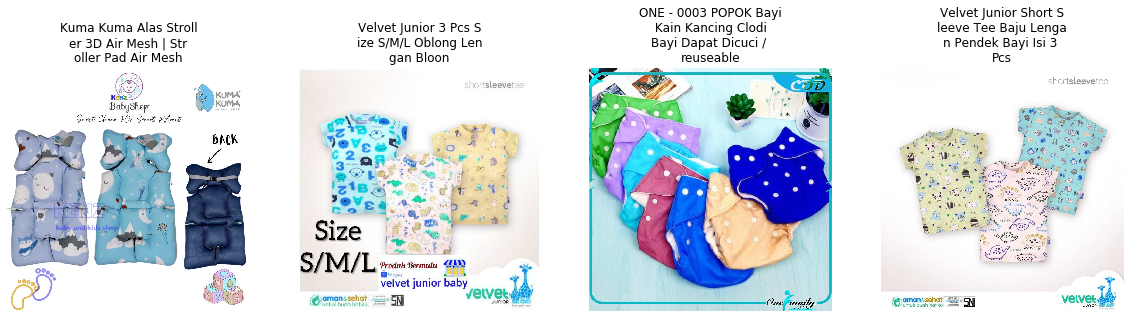

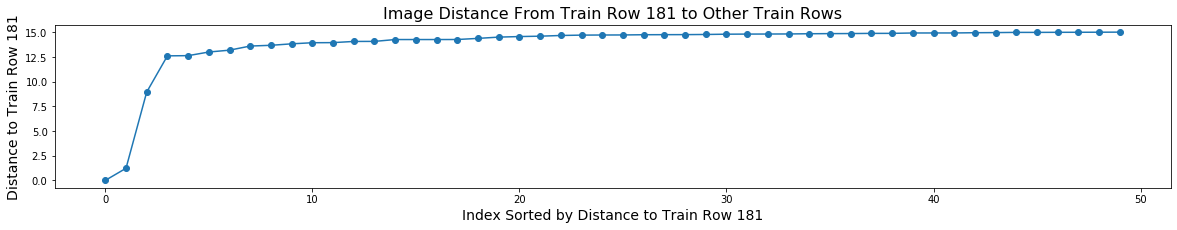

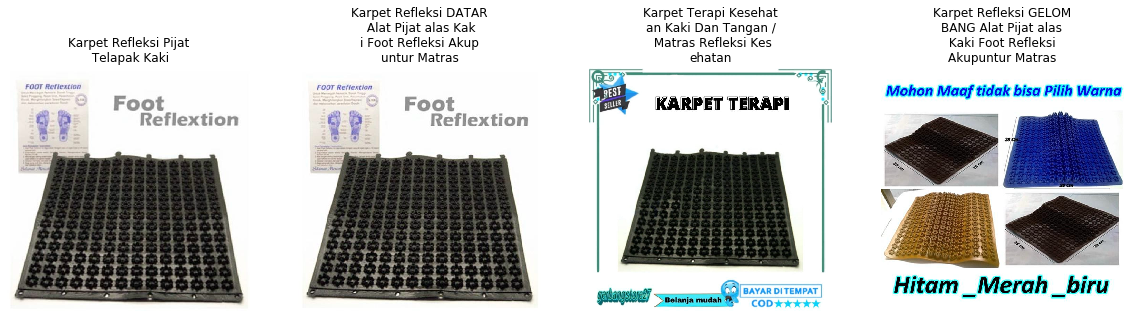

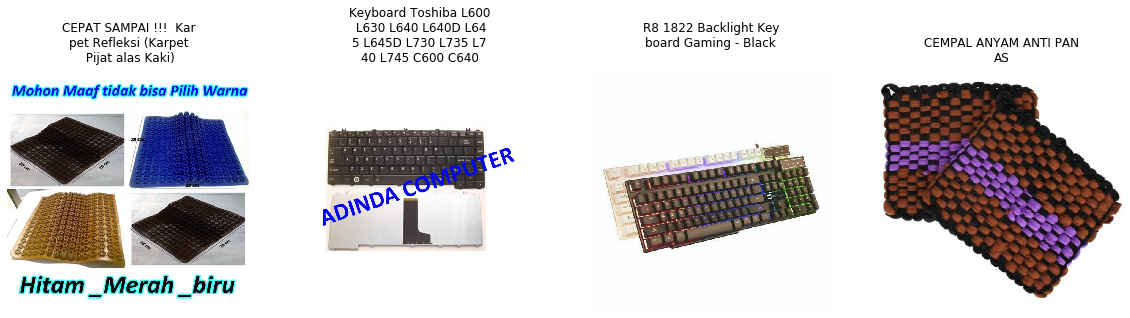

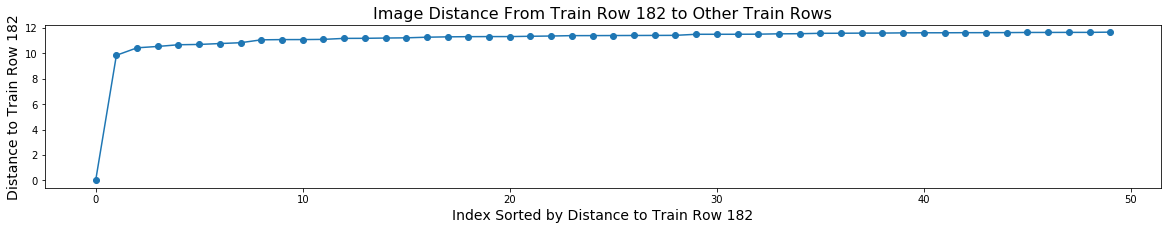

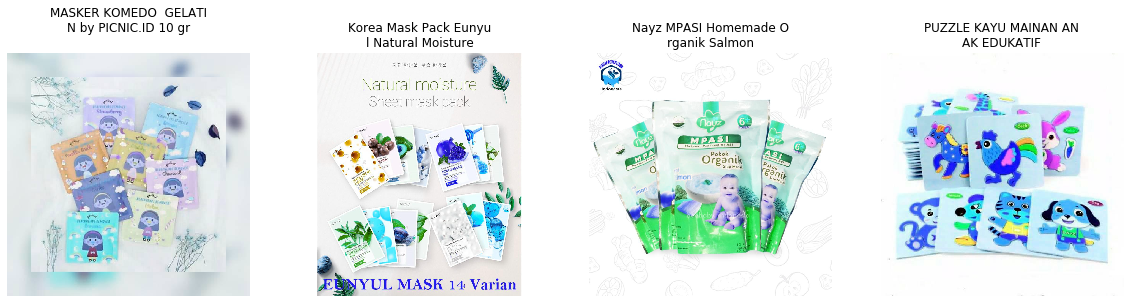

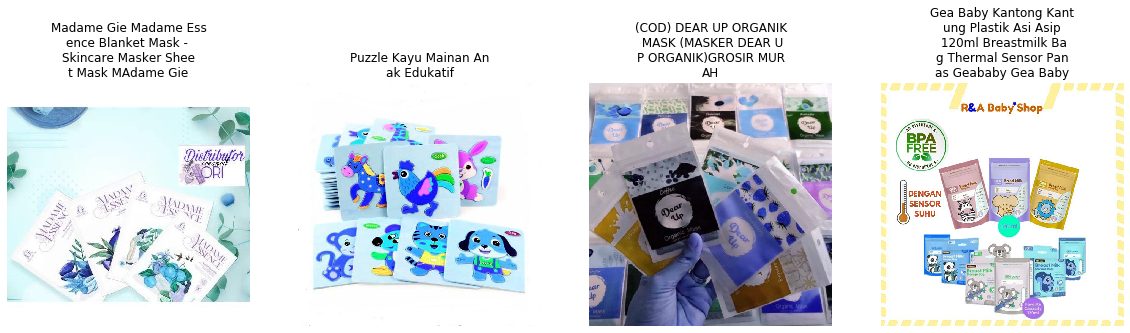

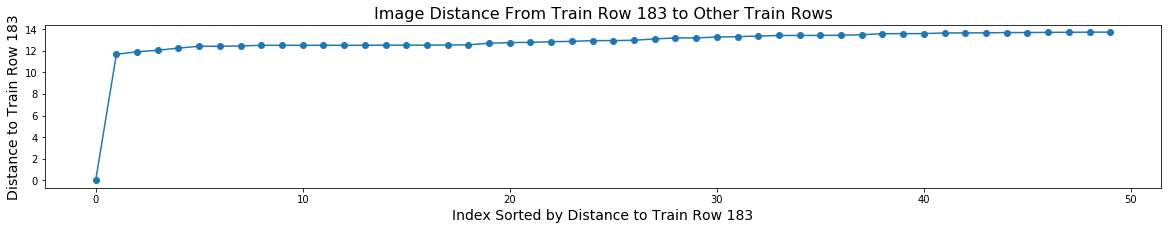

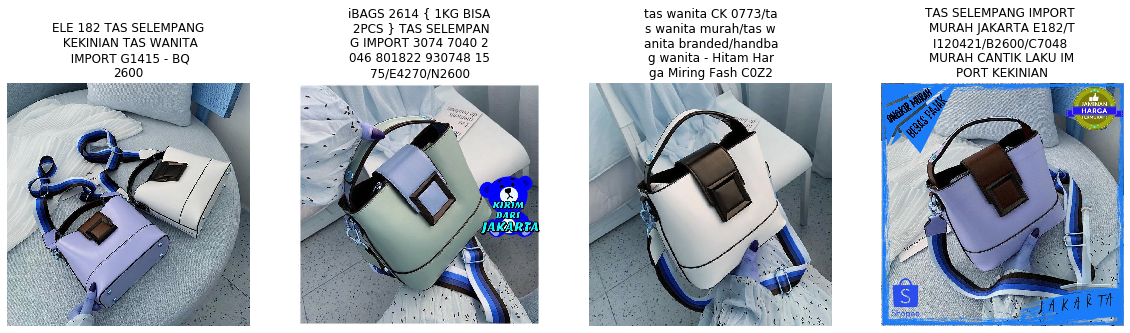

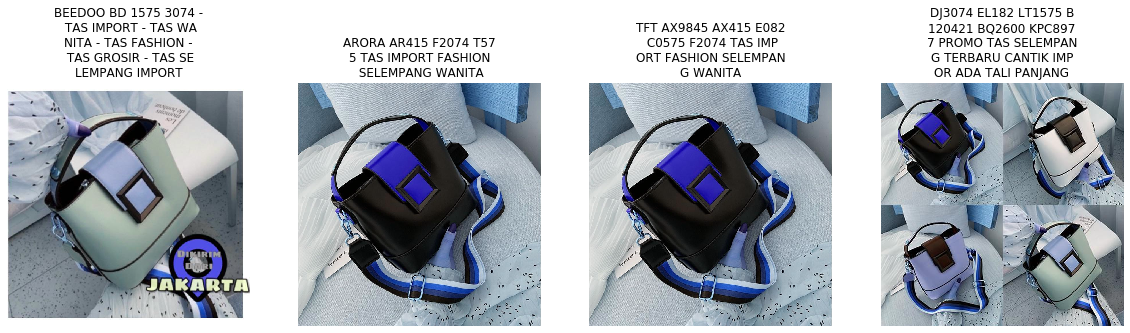

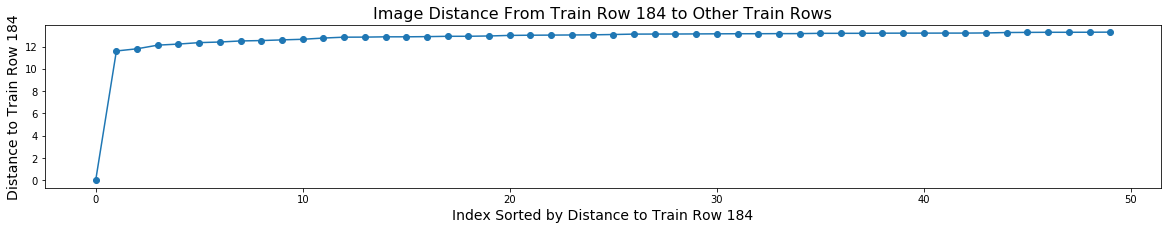

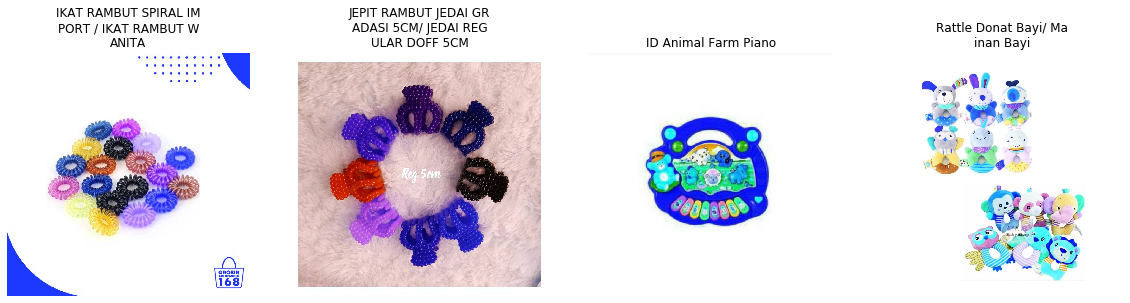

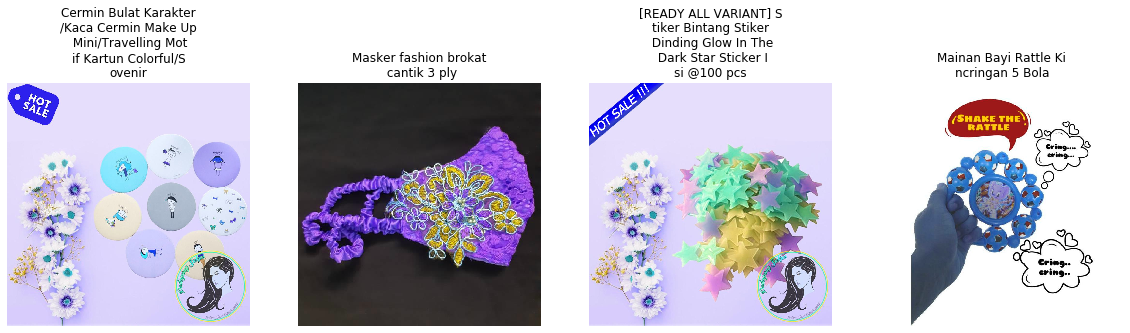

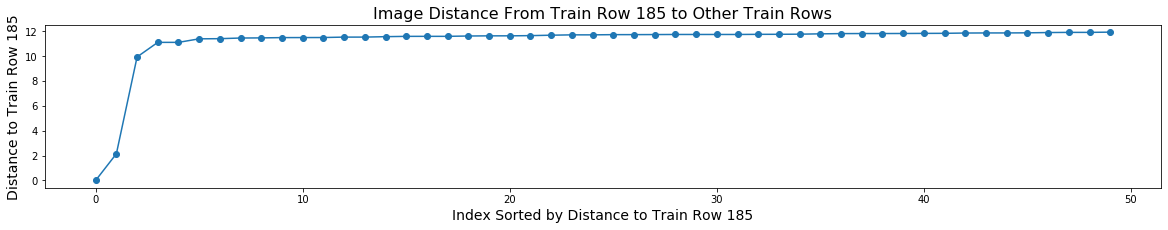

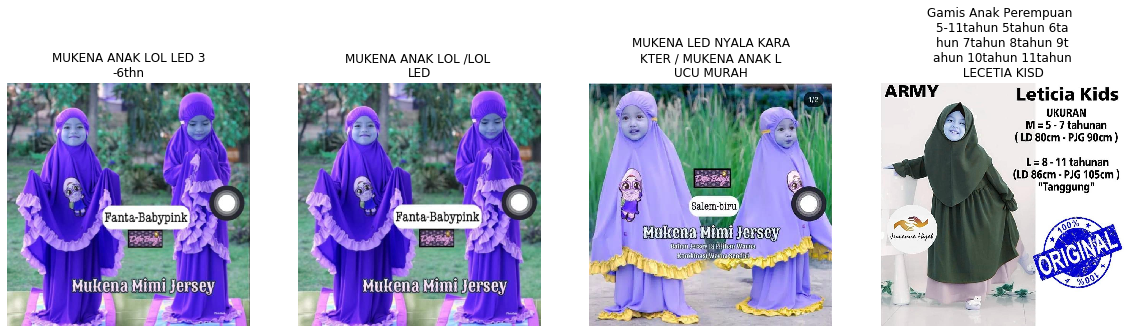

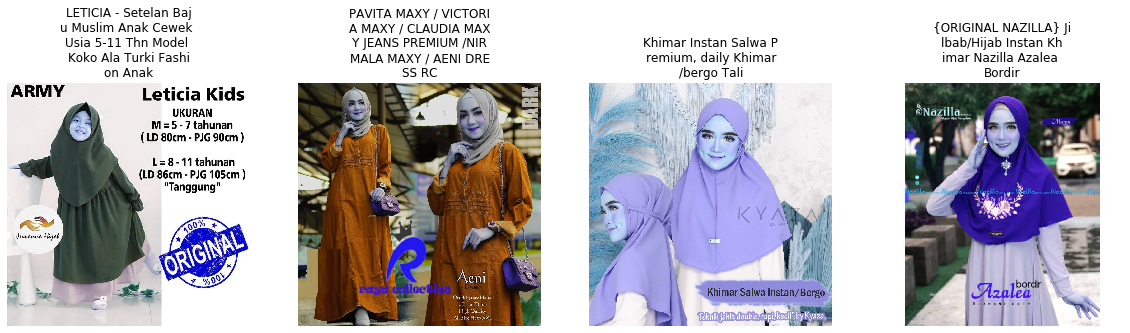

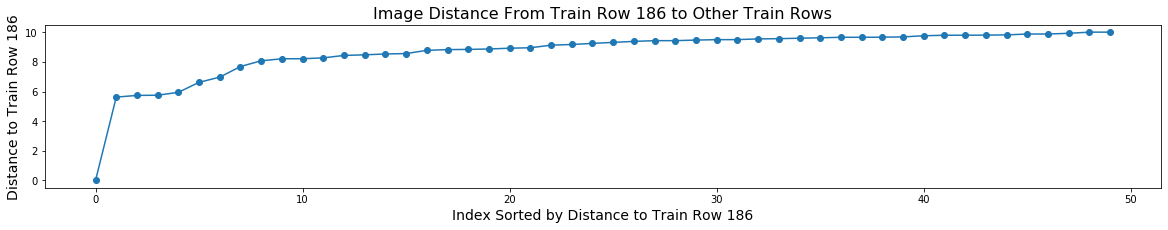

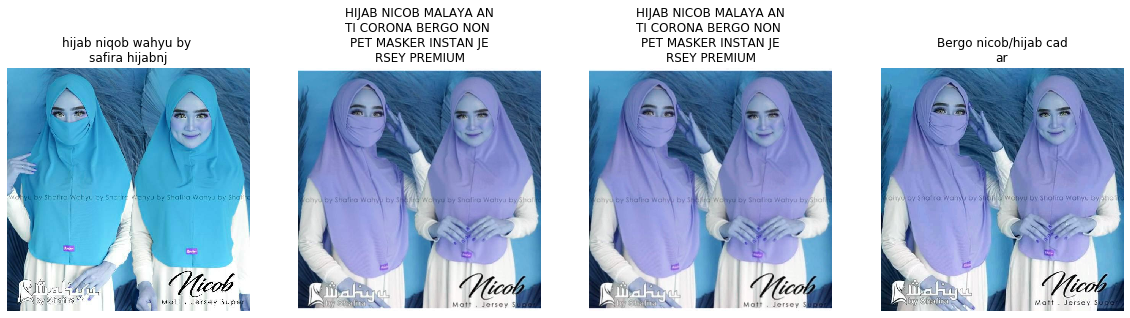

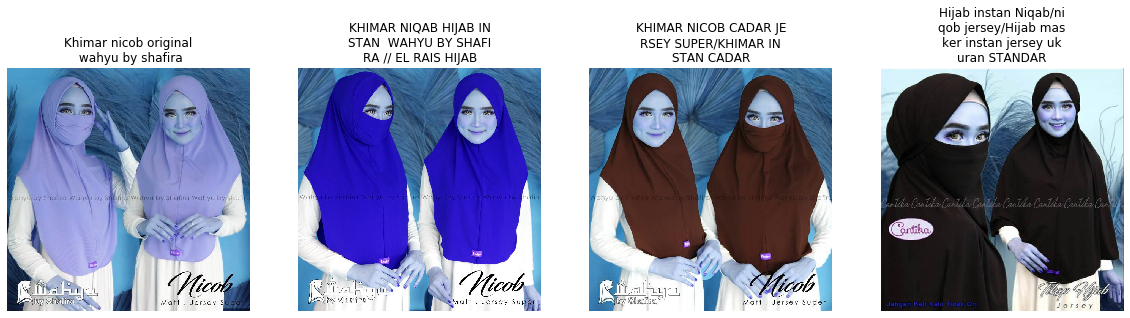

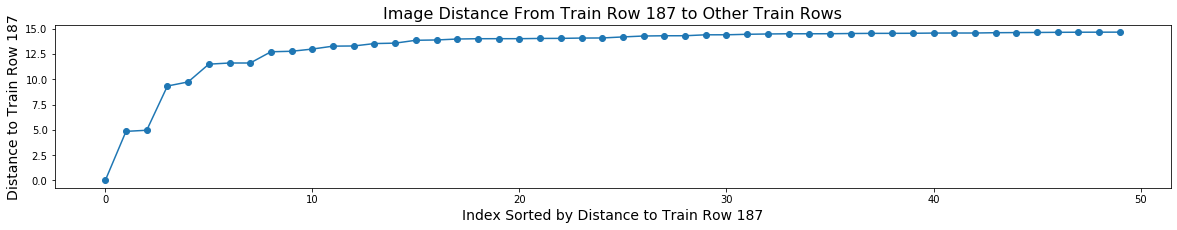

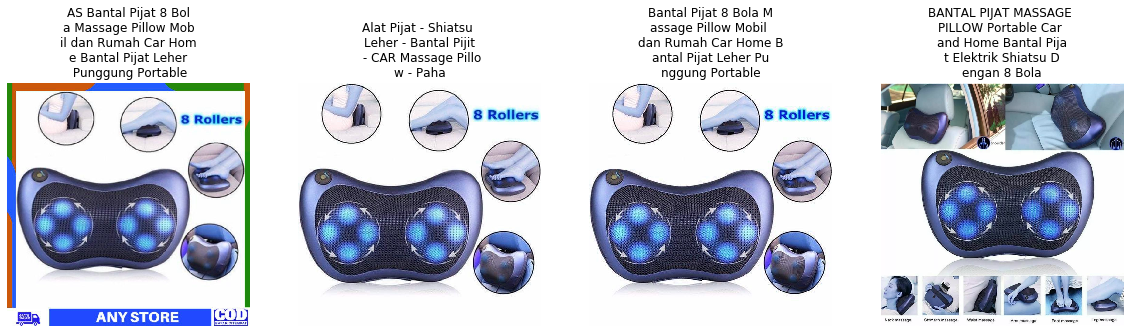

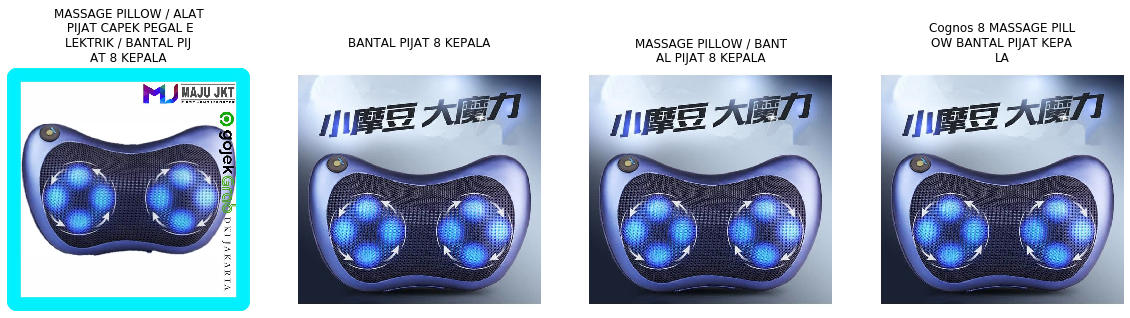

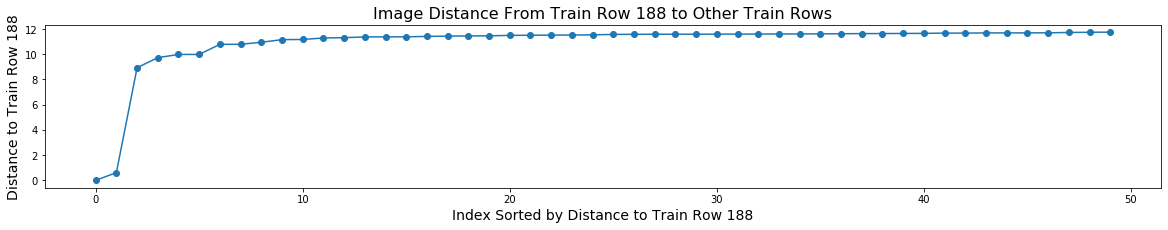

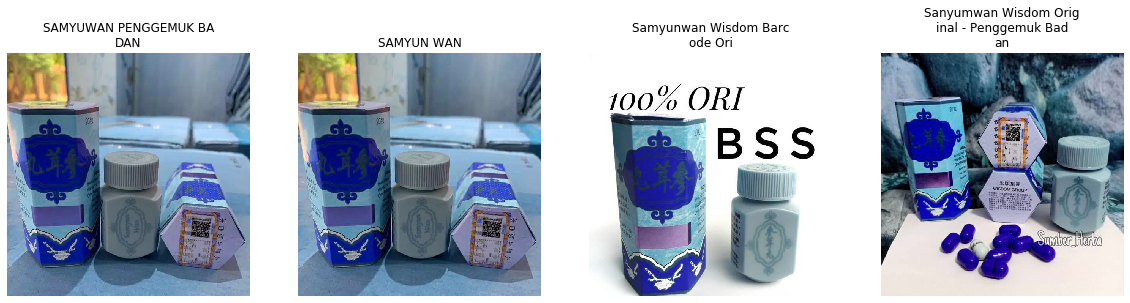

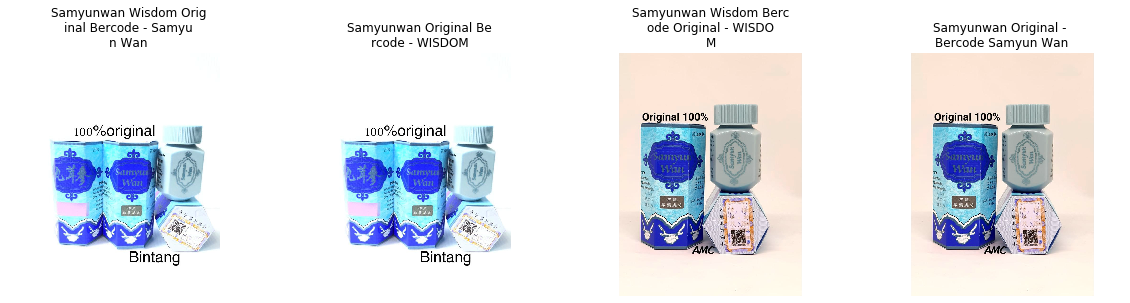

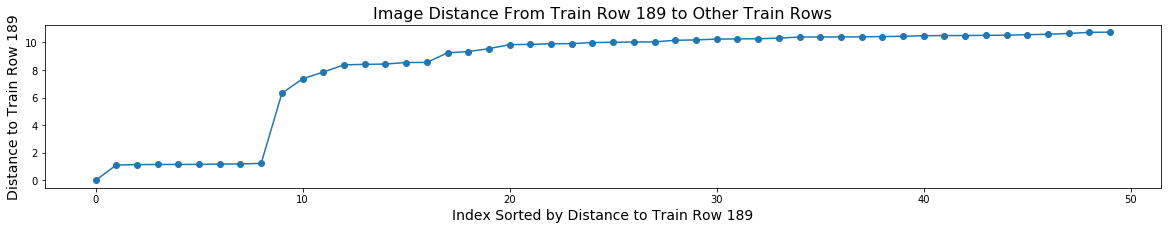

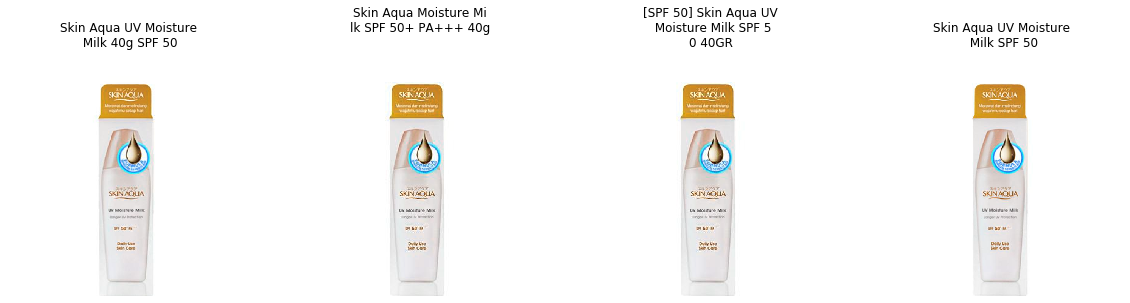

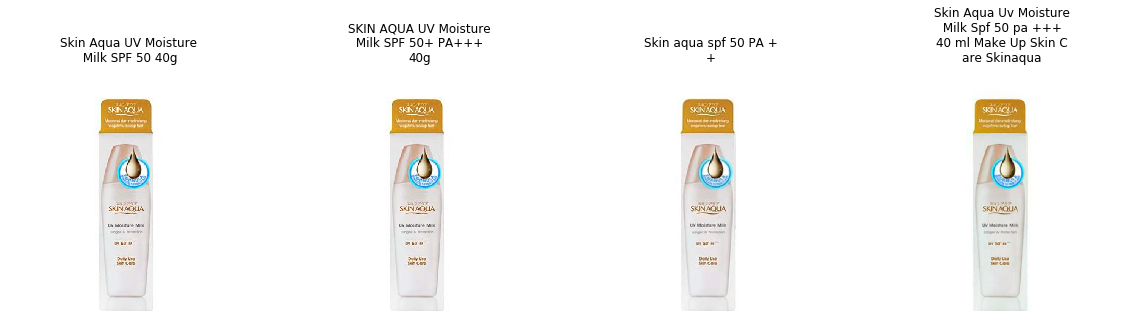

In [15]:
for k in range(180,190):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50), distances[k,],'o-')
    plt.title('Image Distance From Train Row %i to Other Train Rows'%k,size=16)
    plt.ylabel('Distance to Train Row %i'%k,size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k,size=14)
    plt.show()
    
    cluster = train.loc[indices[k,:8]] 
    displayDF(cluster, random=False, ROWS=2, COLS=4)